In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
!git clone https://github.com/uchidalab/softmaxgradient-lrp.git
!git clone https://github.com/albermax/innvestigate.git

Cloning into 'softmaxgradient-lrp'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 166 (delta 7), reused 16 (delta 2), pack-reused 137
Receiving objects: 100% (166/166), 2.31 MiB | 4.69 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Cloning into 'innvestigate'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 5666 (delta 245), reused 219 (delta 132), pack-reused 5317
Receiving objects: 100% (5666/5666), 41.31 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (3970/3970), done.


In [3]:
import sys
sys.path.append('/content/softmaxgradient-lrp/')
sys.path.append('/content/innvestigate/')

In [4]:
!pip install tensorflow==1.15
!pip install keras==2.2.4 

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
     |████████████████████████████████| 512kB 49.9MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=3d887e2e86a0c356abe7f539e759d64203962e806527aa2caa4d21e450dd634d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [5]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP
from utils.visualizations import LRP, CLRP, LRPA, LRPB, LRPE
from utils.visualizations import SGLRP, SGLRPSeqA, SGLRPSeqB
from utils.helper import heatmap
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img
import cv2

Using TensorFlow backend.


In [6]:
from keras.models import load_model, Model
model = load_model('/content/gdrive/My Drive/Last Dataset/log/VGG16_perfect4.h5')

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
__________________________________________________

In [7]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
__________

In [8]:
def load_image(path, preprocess=True):
    img_temp = cv2.imread(path)
    img_temp = cv2.resize(img_temp, img_size)
    img_temp = img_temp.astype('float32') / 255.0 
    if preprocess:
        img_temp= np.array(img_temp)
        img_temp = np.expand_dims(img_temp, axis=0)
    return img_temp

In [9]:
a=['/content/gdrive/My Drive/TEst Lrp/Test/Safe/safe (1).png',
   '/content/gdrive/My Drive/TEst Lrp/Test/Safe/safe (20).png',
   '/content/gdrive/My Drive/TEst Lrp/Test/Unsafe/Unsafe (104).png',
   '/content/gdrive/My Drive/TEst Lrp/unsafeUp22.png',
   '/content/gdrive/MyDrive/Last Dataset/test/unsafe. (60).png']

max_input = 151.061
min_input = -123.68

path="/content/gdrive/MyDrive/unsafe. (10).png"

mapping = {0:'safe', 1:'Unsafe'}

img_size = (400,400)
cls=-1

Model prediction: Unsafe

Probabilities:
	0. safe	-->0.033
	1. Unsafe	-->0.967
Explanation for 'Unsafe':


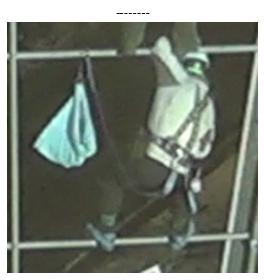

In [10]:
preprocessed_input = load_image(path)
predictions = model.predict(preprocessed_input)
top = np.argmax(predictions)
print('Model prediction: '+ mapping[top])
print()
print('Probabilities:')
for i in range(2):
  print('\t{}. {}\t-->{:.3f}'.format(i, mapping[i], predictions[0,i]))
cls = np.argmax(predictions)
print("Explanation for '{}':".format(mapping[cls]))
plt.title('--------')
plt.axis('off')
plt.imshow(load_image(path, preprocess=False))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

(4, 400, 400, 3)
[[0. 1.]]


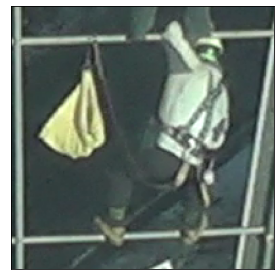

In [11]:

orig_imgs = [img_to_array(load_img(path.format(i+1), target_size=(img_size))) for i in range(4)]
input_imgs = np.copy(orig_imgs)
print(np.shape(input_imgs))

# preprocess input for model
input_imgs = preprocess_input(input_imgs) #for built in keras models

image12 = load_img(path, target_size=(img_size))

image12 = img_to_array(image12)

image12 = np.expand_dims(image12, axis=0)

from keras.applications.vgg16 import preprocess_input

image = preprocess_input(image12)
predictions = model.predict(image12)

print(predictions)
# Select only one from your list for example
example_id = 3

plt.imshow(orig_imgs[example_id].astype(int))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [12]:
# Which class you want to target.
target_class = 0 # ImageNet "zebra"
use_relu = False
# GradCAM and GuidedGradCAM requires a specific layer
target_layer = "block5_pool" # VGG only
# Optional
predictions = model.predict(input_imgs)
pred_id = np.argmax(predictions[example_id])
#print(decode_predictions(predictions))
print("prediction id:", pred_id)
print("target id:", target_class)
target_class=pred_id

prediction id: 1
target id: 0


/content/softmaxgradient-lrp/utils/visualizations.py:145: RuntimeWarning: divide by zero encountered in true_divide
  axis=(1, 2, 3), keepdims=True)
/content/softmaxgradient-lrp/utils/visualizations.py:146: RuntimeWarning: invalid value encountered in multiply
  analysis = analysis_target - analysis_others * equal_magnification


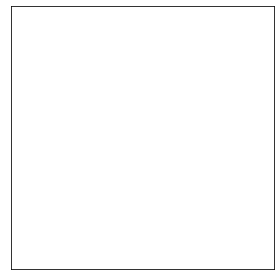

CLRP


/content/softmaxgradient-lrp/utils/visualizations.py:145: RuntimeWarning: divide by zero encountered in true_divide
  axis=(1, 2, 3), keepdims=True)
/content/softmaxgradient-lrp/utils/visualizations.py:146: RuntimeWarning: invalid value encountered in multiply
  analysis = analysis_target - analysis_others * equal_magnification


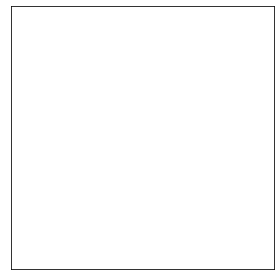

SGLRP


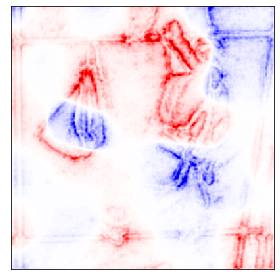

SGLRP Sequential A


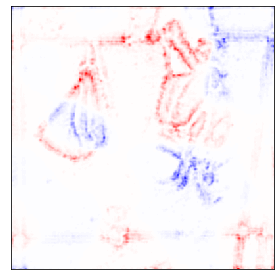

SGLRP Sequential B


In [15]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=use_relu,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(input_imgs)
img1=heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()
print('CLRP')

sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=use_relu,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(input_imgs)
img2=heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()
print('SGLRP')

sglrpa_analyzer = SGLRPSeqA(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_sglrpa = sglrpa_analyzer.analyze(input_imgs)
img3=heatmap(analysis_sglrpa[example_id].sum(axis=(2)))
plt.show()
print('SGLRP Sequential A')

sglrpb_analyzer = SGLRPSeqB(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_sglrpb = sglrpb_analyzer.analyze(input_imgs)
img4=heatmap(analysis_sglrpb[example_id].sum(axis=(2)))
plt.show()
print('SGLRP Sequential B')
#####################################################################################################


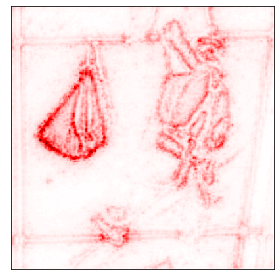

lrp


In [14]:
lrp_analyzer = LRP(
      partial_model,
      target_id=target_class,
      relu=use_relu,
      low=min_input,
      high=max_input,
  )
analysis_lrp = lrp_analyzer.analyze(input_imgs)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()
print('lrp')
